In [1]:
!pip install yfinance
import yfinance as yf
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
from datetime import datetime

# Get today's date
end_date = datetime.today().strftime('%Y-%m-%d')

# Download data from start date to today's date
df = yf.download('BTC-USD', start='2012-01-01', end=end_date)


[*********************100%***********************]  1 of 1 completed


In [3]:
print(df)
print(df.shape)


                    Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2024-11-06  69358.500000  76460.156250  69322.031250  75639.078125   
2024-11-07  75637.085938  76943.117188  74480.421875  75904.859375   
2024-11-08  75902.835938  77252.750000  75648.742188  76545.476562   
2024-11-09  76556.187500  76932.765625  75773.789062  76778.867188   
2024-11-10  76775.546875  81474.421875  76565.429688  80474.187500   

               Adj Close        Volume  
Date                                    
2014-09

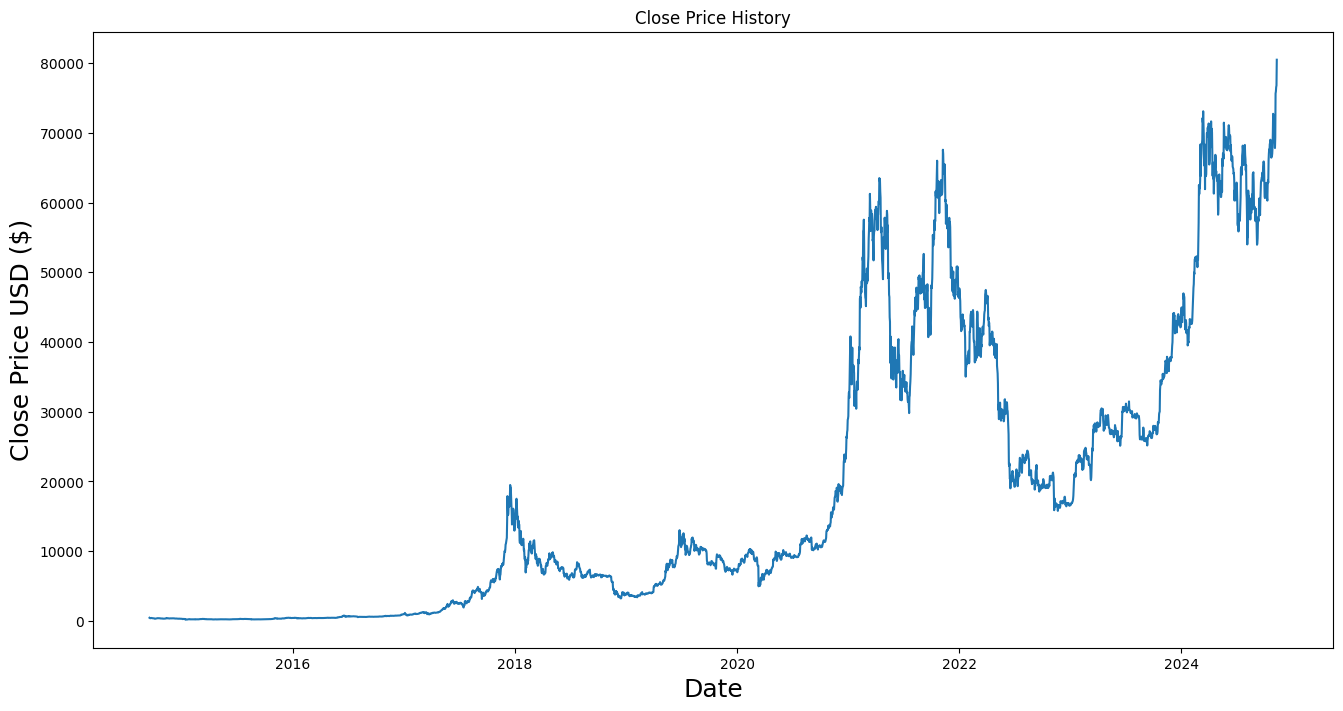

In [4]:
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


In [5]:
data = df[['Close']]
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)


2967


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [7]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [9]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\rajem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.0031 - val_loss: 0.0111
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 7.4946e-04 - val_loss: 0.0031
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 2.9529e-04 - val_loss: 0.0043
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 3.1454e-04 - val_loss: 0.0011
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 3.0113e-04 - val_loss: 0.0012
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 2.1644e-04 - val_loss: 0.0022
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 2.4069e-04 - val_loss: 0.0011
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 2.8862e-04 - val_loss: 0.0013
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 2.1830e-04 - val_loss: 8.5146e-04
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 2.2940e-04 - val_loss: 0.0061
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 5.6234e-04 - val_loss: 

In [11]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [12]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Root Mean Squared Error (RMSE): {rmse}')


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Root Mean Squared Error (RMSE): 1641.4766349000845


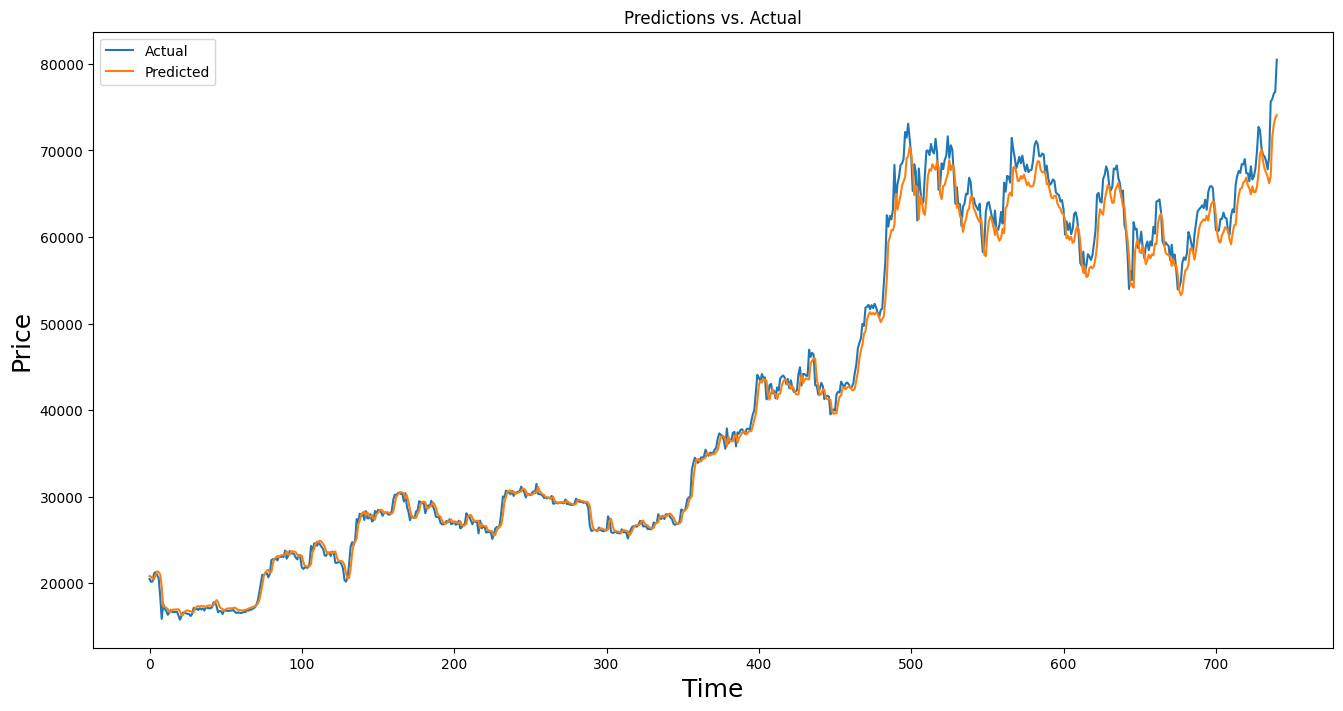

In [13]:
plt.figure(figsize=(16, 8))
plt.title('Predictions vs. Actual')
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend()
plt.show()


In [14]:
last_60_days = scaled_data[-60:, :]
last_60_days = np.reshape(last_60_days, (1, last_60_days.shape[0], 1))
tomorrow_prediction = model.predict(last_60_days)
tomorrow_prediction = scaler.inverse_transform(tomorrow_prediction)
print("Predicted price for tomorrow:", tomorrow_prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted price for tomorrow: 76602.664
